# toywv-11

## references

- <https://medium.com/@panghalarsh/sentiment-analysis-in-python-using-keras-glove-twitter-word-embeddings-and-deep-rnn-on-a-combined-580646cb900a>
- <https://ahmedbesbes.com/sentiment-analysis-on-twitter-using-word2vec-and-keras.html>

In [1]:
%autosave 120
import warnings
warnings.filterwarnings("ignore")

from psychedelic.jupyter_implicit import *
environment_printout(preferred_device='GeForce')

Autosaving every 120 seconds


Using TensorFlow backend.


Python version: 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
Keras version: 2.2.4-tf
Matplotlib version: 3.1.3
NumPy version: 1.18.1
TensorFlow version: 2.1.0
Keras-Vis version:  0.5.0

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7500428084
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7722249686463323260
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"



In [2]:
from adjustText import adjust_text
import ast
import gensim.models.doc2vec
from gensim.models.word2vec import Word2Vec
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from nltk.tokenize import TweetTokenizer
import sklearn.manifold
from sklearn.model_selection import train_test_split
import sqlite3
from tqdm import tqdm

tokenizer = TweetTokenizer()
LabeledSentence = gensim.models.doc2vec.LabeledSentence

def tokenize(tweet):
    try:
        #tweet = unicode(tweet.decode('utf-8').lower())
        tokens = tokenizer.tokenize(tweet)
        tokens = filter(lambda t: not t.startswith('@'), tokens)
        tokens = filter(lambda t: not t.startswith('#'), tokens)
        tokens = filter(lambda t: not t.startswith('http'), tokens)
        return list(tokens)
    except:
        return 'NC'

def postprocess(data):
    data['tokens'] = data['SentimentText'].progress_map(tokenize)
    data = data[data.tokens != 'NC']
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    return data

def labelize_tweets(tweets, label_type):
    labelized = []
    for i, v in enumerate(tweets):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

In [3]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (17, 17)

In [4]:
#df = pd.read_sql("SELECT * FROM Twitter", con=sqlite3.connect("Twitter.db"))
#df["datetime"] = pd.to_datetime(df["time_UNIX"], unit='ms')

In [5]:
df = pd.read_sql("SELECT * FROM exchanges", con=sqlite3.connect("database.db"))
df["utteranceDatetime"] = pd.to_datetime(df["utteranceTimeUNIX"], unit='s')
df["responseDatetime"] = pd.to_datetime(df["responseTimeUNIX"], unit='s')

In [6]:
#df = df[:1000]
df.head(n=2)

,id,utterance,responseTimeUNIX,utteranceTimeUNIX,utteranceReference,exchangeReference,response,responseReference,utteranceDatetime,responseDatetime
0,1,Nobel Peace Prize Winners Want Barack Obama to...,1414490026.0,1414487610.0,http://www.reddit.com/r/worldnews/comments/2kj...,worldnews,Nobel Peace Prize winner says No.,http://www.reddit.com/r/worldnews/comments/2kj...,2014-10-28 09:13:30,2014-10-28 09:53:46
1,2,Pope says evolution doesn't mean there's no Go...,1414452569.0,1414451169.0,http://www.reddit.com/r/worldnews/comments/2ki...,worldnews,The Catholic Church has been claiming divinely...,http://www.reddit.com/r/worldnews/comments/2ki...,2014-10-27 23:06:09,2014-10-27 23:29:29


In [7]:
max_sentence_length         = 12
dimensionality_word_vectors = 70

In [8]:
%%time
df['utteranceTokens'] = df.apply(lambda row: str(tokenize(row['utterance'])), axis=1)
df['responseTokens']  = df.apply(lambda row: str(tokenize(row['response'])), axis=1)

utterance_tokens = [ast.literal_eval(i) for i in df['utteranceTokens'].values]
response_tokens  = [ast.literal_eval(i) for i in df['responseTokens'].values]

x_train, x_test, y_train, y_test = train_test_split(utterance_tokens, response_tokens, test_size=0.1)

x_train = labelize_tweets(x_train, 'TRAIN')
x_test  = labelize_tweets(x_test, 'TEST')

tweet_w2v = Word2Vec(size=dimensionality_word_vectors, min_count=2)
tweet_w2v.build_vocab([x.words for x in tqdm(x_train)])
tweet_w2v.train([x.words for x in tqdm(x_train)], total_examples=len(x_train), epochs=10)
print(len(tweet_w2v.wv.vocab))
tweet_w2v.most_similar('future')

100%|██████████| 101373/101373 [00:00<00:00, 1661609.20it/s]


35601
CPU times: user 1min 41s, sys: 315 ms, total: 1min 41s
Wall time: 1min 23s


[('atmosphere', 0.6907221078872681),
 ('process', 0.6822072267532349),
 ('current', 0.6800694465637207),
 ('rest', 0.6691430807113647),
 ('world', 0.6594160199165344),
 ('country', 0.658780038356781),
 ('goal', 0.6506198048591614),
 ('internet', 0.6381411552429199),
 ('race', 0.6377385854721069),
 ('step', 0.6357293725013733)]

In [9]:
#%%time
#n = 20000
#word_vectors = [tweet_w2v[w] for w in tweet_w2v.wv.vocab][:n]
#labels = [w for w in tweet_w2v.wv.vocab][:n]
#for i in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
#    print(i)
#    np.random.seed(1337)
#    _umap = umap.UMAP(n_neighbors=i).fit_transform(word_vectors)
#    x = _umap[:, 0]
#    y = _umap[:, 1]
#    plt.scatter(x, y, marker='o', s=5, facecolor='red', label=labels)
#    plt.show();

In [10]:
%%time
n = 20000
word_vectors = [tweet_w2v[w] for w in tweet_w2v.wv.vocab][:n]
labels = [w for w in tweet_w2v.wv.vocab][:n]
np.random.seed(1337)
_umap = umap.UMAP(n_neighbors=6).fit_transform(word_vectors)
x = _umap[:, 0]
y = _umap[:, 1]

CPU times: user 23.4 s, sys: 1.39 s, total: 24.8 s
Wall time: 21.6 s


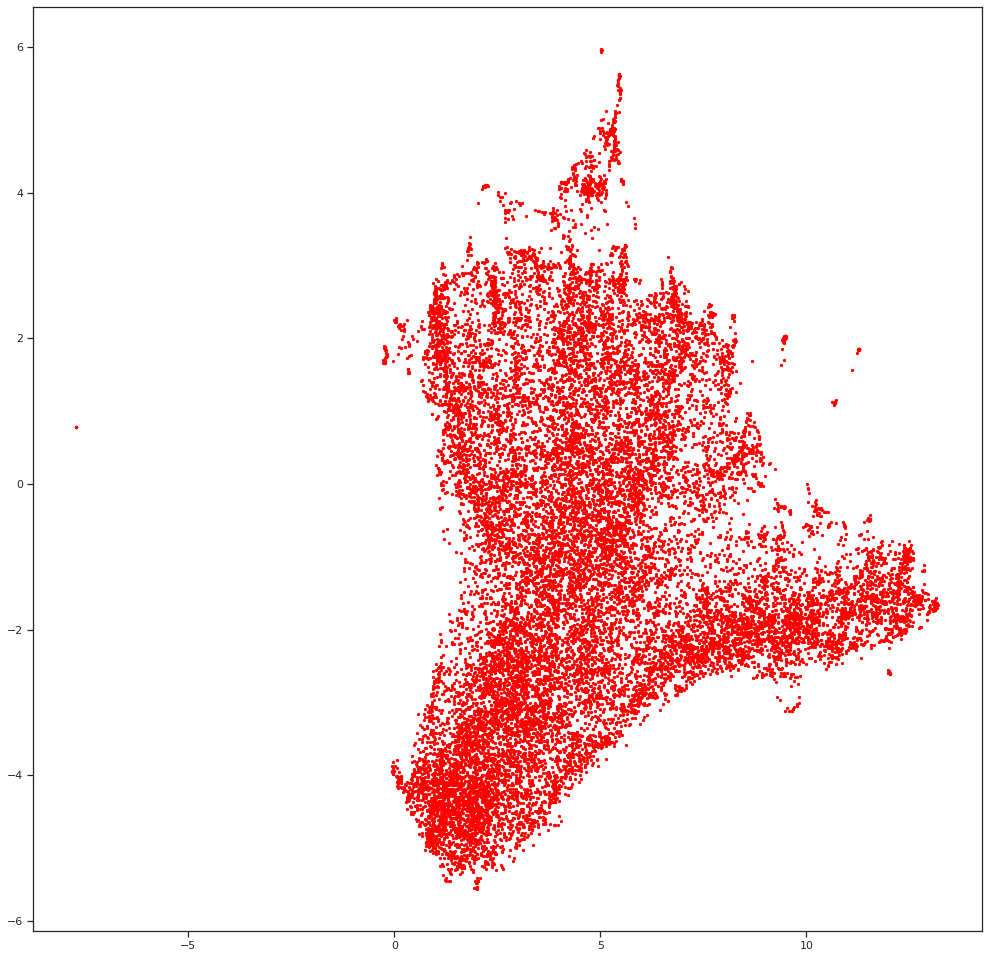

In [11]:
plt.scatter(x, y, marker='o', s=5, facecolor='red', label=labels);

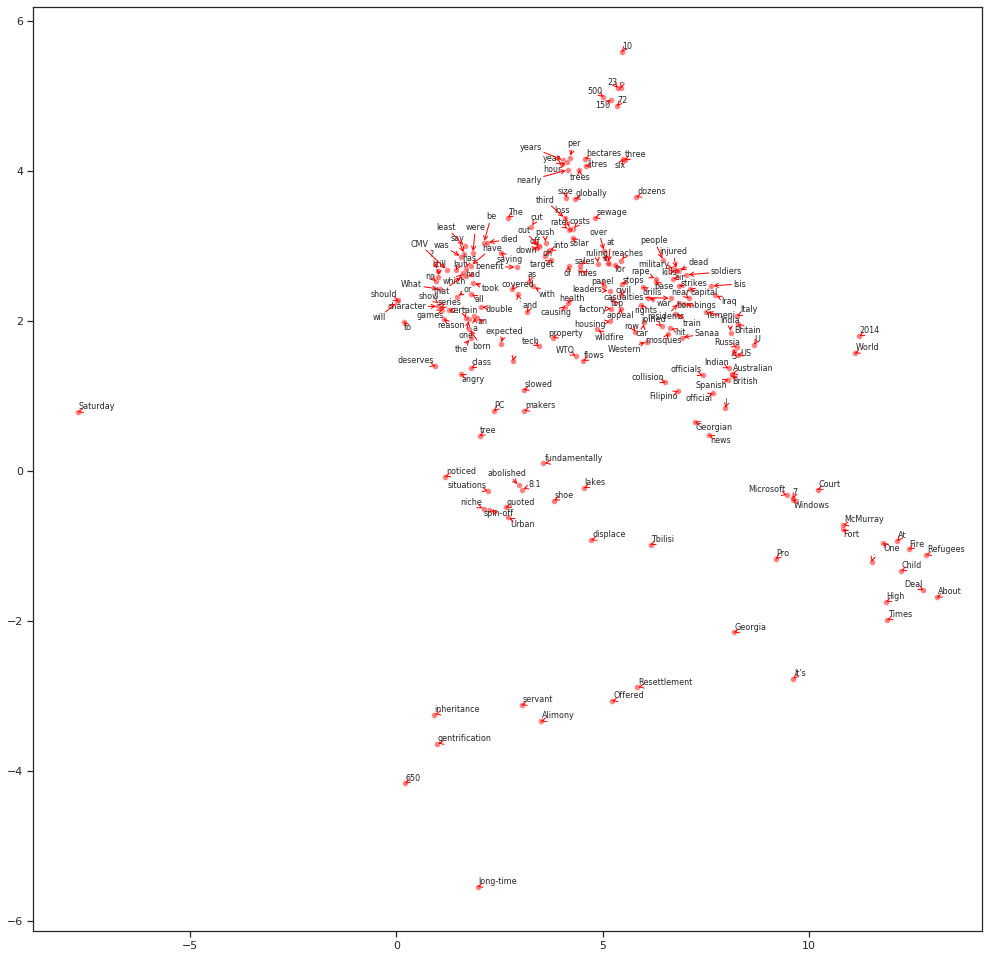

CPU times: user 1min 52s, sys: 2.7 s, total: 1min 55s
Wall time: 1min 53s


In [37]:
%%time
m=200
for point, label in zip(_umap[:m], labels[:m]):
    plt.scatter(point[0], point[1], alpha=0.5, edgecolor='white', facecolor='red')
texts = []
for point, label in zip(_umap[:m], labels[:m]):
    texts.append(plt.text(point[0], point[1], label, size=8))
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
plt.show();

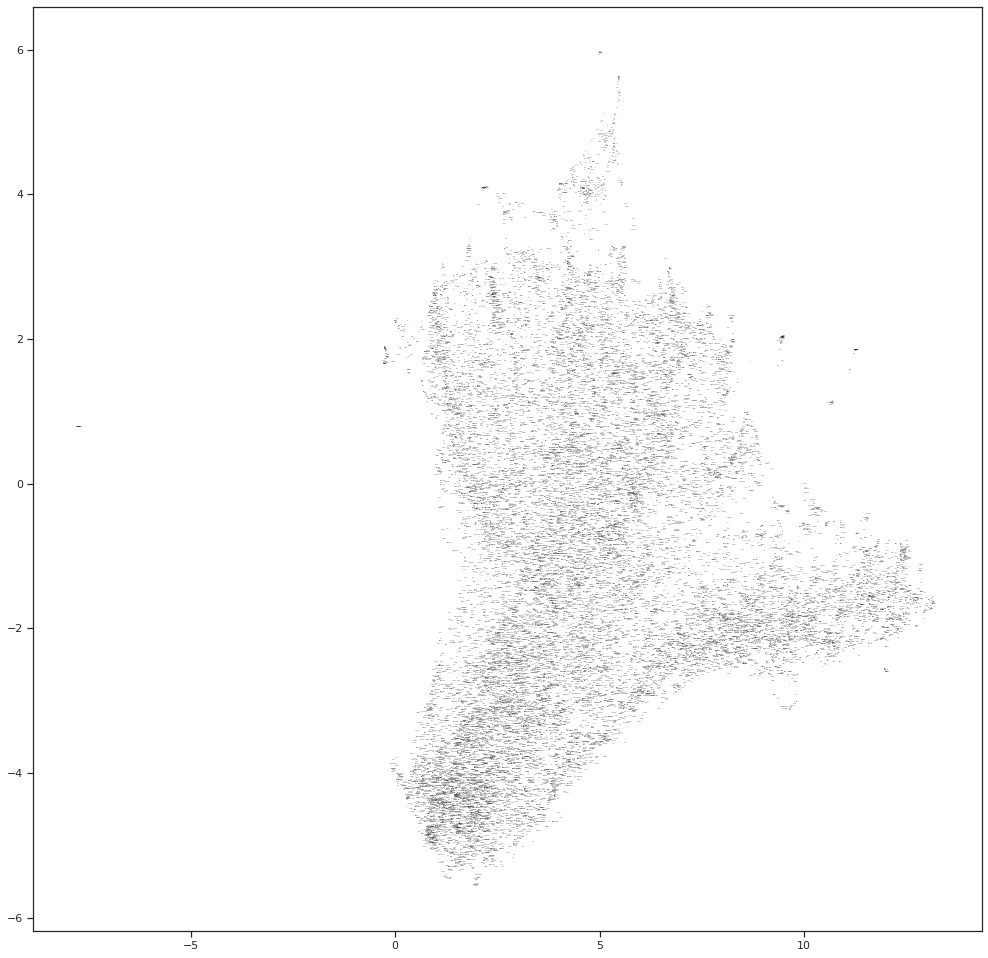

CPU times: user 7min 30s, sys: 2min 56s, total: 10min 27s
Wall time: 5min 2s


In [13]:
%%time
m=30000
for point, label in zip(_umap[:m], labels[:m]):
    plt.scatter(point[0], point[1], alpha=0, edgecolor='white', facecolor='red')
#texts = []
#for point, label in zip(_umap[:m], labels[:m]):
#    texts.append(plt.text(point[0], point[1], label, size=8))
#adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
for point, label in zip(_umap[:m], labels[:m]):
    plt.axes().annotate(label, (point[0], point[1]), ha='center', size=1)
plt.savefig("toywv_UMAP.svg");
plt.show();

A sentence image is an image formed from the word vectors of a sentence being arranged as vertical columns of pixels. The word columns are arranged from left to right, as words in an English sentence are arranged from left to right. For reasons of standardization, sentences are padded with null vectors at the right of the sentence image.

In [14]:
def word_string_to_word_vector(word):
    try:
        return tweet_w2v[word]
    except:
        return np.zeros(dimensionality_word_vectors)

def sentence_tokens_to_sentence_image(sentence, max_length=max_sentence_length):
    sentence = ast.literal_eval(sentence)
    sentence = sentence[:max_length]
    _sentence_image = []
    for word in sentence:
        word_vector = word_string_to_word_vector(word)
        _sentence_image.append(word_vector)
        #print(word, tweet_w2v.most_similar(positive=[word_vector], topn=1)[0][0])
    padding = [word_string_to_word_vector('') for i in range(0, max_length - len(sentence))]
    sentence_image = np.stack(_sentence_image+padding, axis=1)
    return sentence_image

def sentence_image_to_sentence_string(sentence_image):
    sentence_tokens = []
    for word_column in sentence_image.T:
        sentence_tokens.append(tweet_w2v.most_similar(positive=[word_column], topn=1)[0][0])
    return ' '.join(sentence_tokens)

In [15]:
%%time
utteranceImages = []
responseImages  = []
for utteranceToken, responseToken in zip(df['utteranceTokens'].values, df['responseTokens'].values):
    _ = sentence_tokens_to_sentence_image(utteranceToken)
    utteranceImages.append(_)
    _ = sentence_tokens_to_sentence_image(responseToken)
    responseImages.append(_)

CPU times: user 34.6 s, sys: 350 ms, total: 34.9 s
Wall time: 34.9 s


In [16]:
sentence_image = utteranceImages[0]
sentence_image_to_sentence_string(sentence_image)

'Nobel Peace Prize Winners Want Barack Obama to Release Torture Report to'

In [42]:
# mean of word vectors
words = ['King', 'Queen']
wvs   = [word_string_to_word_vector(word) for word in words]
wv_mean = np.mean(wvs, axis=0)
tweet_w2v.most_similar(positive=[wv_mean], topn=1)[0][0]

'King'

In [18]:
tweet_w2v.most_similar(positive=[wv_mean])

[('King', 0.9686912298202515),
 ('Prince', 0.8255799412727356),
 ('Queen', 0.8179125189781189),
 ('Badawi', 0.7841584086418152),
 ('Khan', 0.7822535037994385),
 ('Salman', 0.7795709371566772),
 ('Raif', 0.7790666818618774),
 ('Princess', 0.7754486203193665),
 ('Grand', 0.7677055597305298),
 ('Sadiq', 0.7658402919769287)]

In [40]:
# arithmetic of word vectors
words = ['queen', 'man', 'woman']
wvs   = [word_string_to_word_vector(word) for word in words]
#print(wvs)
#print(wv_mean)
tweet_w2v.most_similar(positive=[wvs[0]-wvs[1]+wvs[2]], topn=1)[0][0]

'Con'

Nobel Peace Prize Winners Want Barack Obama to Release Torture Report


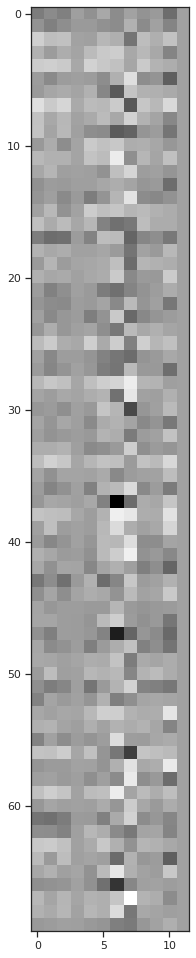

In [20]:
index = 0
print(df['utterance'][index])
#print(utteranceImages[index])
plt.imshow(utteranceImages[index], cmap="Greys", interpolation="nearest")
plt.show();

In [21]:
x_train, x_test, y_train, y_test = train_test_split(utteranceImages, responseImages, test_size=0.1)

In [22]:
x_train = np.array(x_train)
x_test  = np.array(x_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [23]:
x_train.shape

(101373, 70, 12)

In [24]:
x_train[0].shape

(70, 12)

In [25]:
y_train.shape

(101373, 70, 12)

In [26]:
#y_train = y_train.reshape(900, 300*50)
#y_test  = y_test.reshape(100, 300*50)

In [27]:
x_train = x_train.reshape(x_train.shape[0], dimensionality_word_vectors, max_sentence_length, 1)
x_test  = x_test.reshape(x_test.shape[0]  , dimensionality_word_vectors, max_sentence_length, 1)
y_train = y_train.reshape(len(y_train)    , dimensionality_word_vectors*max_sentence_length)
y_test  = y_test.reshape(len(y_test)      , dimensionality_word_vectors*max_sentence_length)

#y_train = y_train.reshape(y_train.shape[0], 300, 50, 1)
#y_test  = y_test.reshape(y_test.shape[0], 300, 50, 1)

In [28]:
x_test[0].shape

(70, 12, 1)

In [29]:
#y_train = y_train.reshape(900, 300*50)
y_test.shape

(11264, 840)

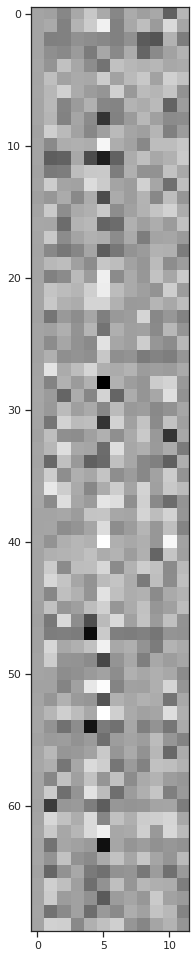

In [30]:
plt.imshow(x_train[0].reshape(dimensionality_word_vectors, max_sentence_length), cmap="Greys", interpolation="nearest");

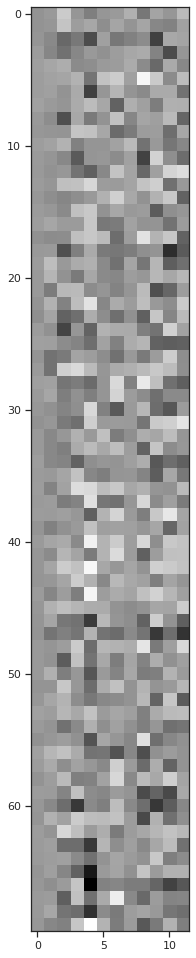

In [31]:
# how to reconstruct an output
plt.imshow(y_train[0].reshape(dimensionality_word_vectors, max_sentence_length), cmap="Greys", interpolation="nearest");
#plt.show()

In [32]:
#input_shape = (dimensionality_word_vectors, max_sentence_length, 1)
#model = Sequential()
#model.add(Conv2D(dimensionality_word_vectors, kernel_size=(3, 1), input_shape=input_shape, activation='tanh'))
#model.add(Conv2D(dimensionality_word_vectors, kernel_size=(5, 1), input_shape=input_shape, activation='tanh'))
##model.add(Conv2D(300, kernel_size=(5, 5), padding='same', input_shape=input_shape, activation='tanh'))
##model.add(Dropout(rate=0.1))
##model.add(MaxPooling2D(pool_size=(2)))
#model.add(Flatten(input_shape=input_shape, name='flatten'))
##model.add(Dropout(rate=0.5))
##model.add(Dense(dimensionality_word_vectors*max_sentence_length, activation='tanh', name='dense'))
#model.add(Dense(dimensionality_word_vectors*max_sentence_length, activation='linear', name='preds'))
#model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=['accuracy'])
#plot_model(model, to_file = "model.png")
#summary_and_diagram(model)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 70, 12, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 70, 12, 70)   140         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 70, 12, 70)   770         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 70, 12, 70)   0           conv2d_1[0][0]                   
____________________________________________________________________________________________

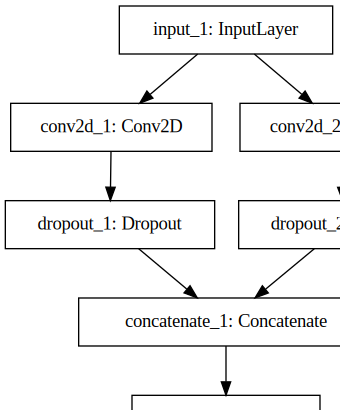

In [33]:
input_shape = (dimensionality_word_vectors, max_sentence_length, 1)
inputs  = Input(input_shape)
x       = inputs

#tower_0 = Dense(dimensionality_word_vectors*max_sentence_length, activation='tanh', name='preds')(x)
#tower_0 = Dropout(rate=0.5)(tower_0)
#tower_0 = Flatten()(tower_0)

#tower_1 = Conv2D(dimensionality_word_vectors, kernel_size=(2, 1), input_shape=input_shape, activation='tanh', border_mode='same')(x)
#tower_1 = Dropout(rate=0.1)(tower_1)
#tower_1 = Conv2D(dimensionality_word_vectors, kernel_size=(2, 1), input_shape=input_shape, activation='tanh', border_mode='same')(tower_1)
#tower_2 = MaxPooling2D(5)(tower_2)
#tower_2 = Flatten()(tower_2)

tower_2 = Conv2D(dimensionality_word_vectors, kernel_size=(1, 1), input_shape=input_shape, activation='tanh', border_mode='same')(x)
tower_2 = Dropout(rate=0.1)(tower_2)
#tower_2 = Conv2D(dimensionality_word_vectors, kernel_size=(3, 1), input_shape=input_shape, activation='tanh', border_mode='same')(x)
#tower_2 = Conv2D(dimensionality_word_vectors, kernel_size=(3, 1), input_shape=input_shape, activation='tanh', border_mode='same')(tower_2)
#tower_2 = Dropout(rate=0.1)(tower_2)
#tower_2 = MaxPooling2D(5)(tower_2)
#tower_2 = Flatten()(tower_2)

tower_3 = Conv2D(dimensionality_word_vectors, kernel_size=(10, 1), input_shape=input_shape, activation='tanh', border_mode='same')(x)
#tower_3 = Conv2D(dimensionality_word_vectors, kernel_size=(5, 1), input_shape=input_shape, activation='tanh', border_mode='same')(tower_3)
tower_3 = Dropout(rate=0.1)(tower_3)
#tower_3 = MaxPooling2D(5)(tower_3)
#tower_3 = Flatten()(tower_3)

x       = concatenate([tower_2, tower_3], axis=2)
x       = Flatten()(x)
#x       = Dense(dimensionality_word_vectors*max_sentence_length, activation='tanh')(x)
#x       = Dropout(rate=0.5)(x)
preds   = Dense(dimensionality_word_vectors*max_sentence_length, activation='tanh', name='preds')(x)

model   = Model(input=inputs, output=preds)
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
summary_and_diagram(model)

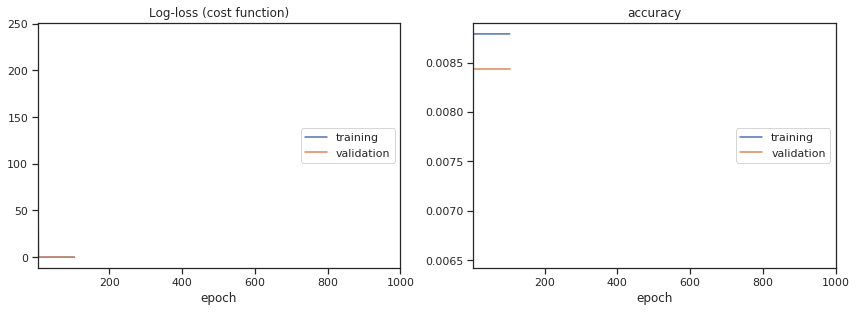

Log-loss (cost function):
training   (min:    0.000, max:  286.150, cur:    0.000)
validation (min:    0.000, max:  566.292, cur:    0.000)

accuracy:
training   (min:    0.002, max:    0.009, cur:    0.009)
validation (min:    0.000, max:    0.008, cur:    0.008)
epoch 104 of epochs 1000 (ETA: 2020-02-17T222208Z)
Restoring model weights from the end of the best epoch
Epoch 00104: early stopping
save to 2020-02-17T190454Z_toywv-11_model.ph5
max. test accuracy observed: 0.008433949202299118
max. test accuracy history index: 2


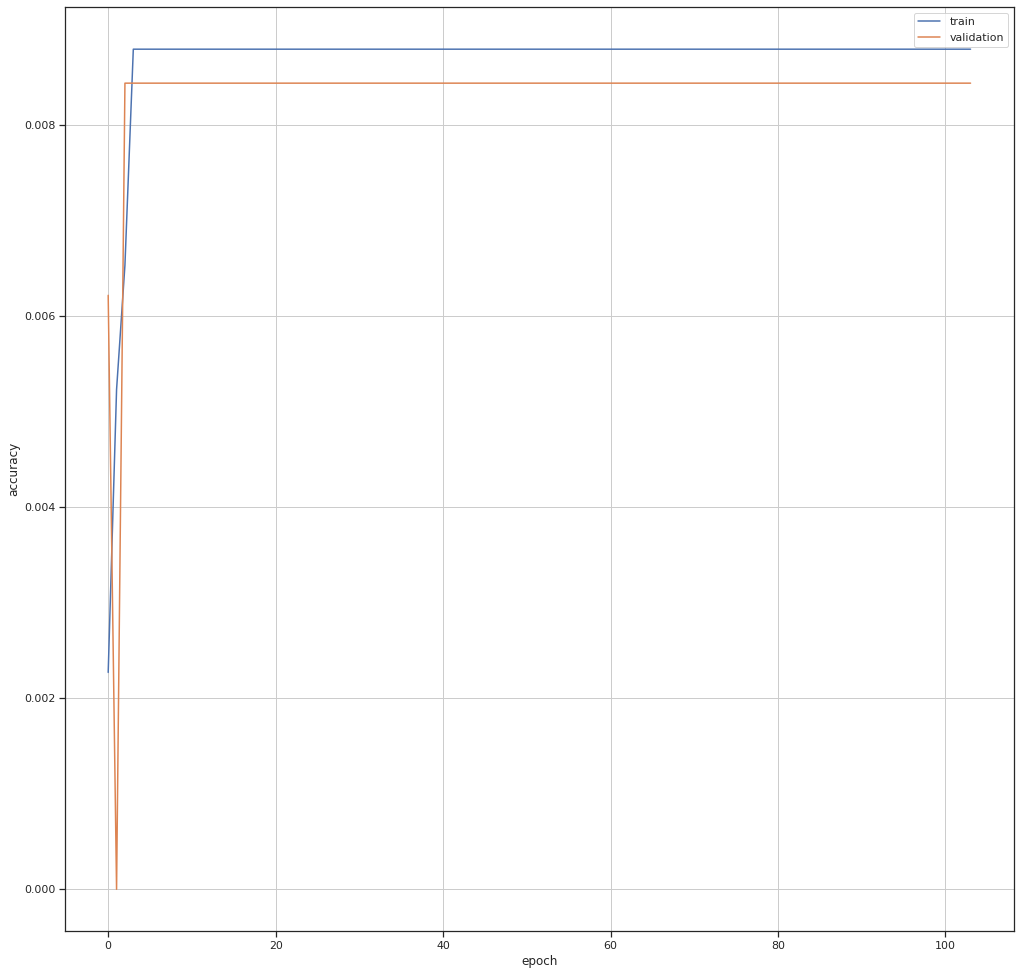

CPU times: user 58min 30s, sys: 21min 7s, total: 1h 19min 37s
Wall time: 1h 38min 41s


In [34]:
%%time
model_name='toywv-11'
stop_early_with_manual = EarlyStoppingWithManualStop(
    filename             = 'safeword_'+model_name,
    monitor              = 'val_loss',
    min_delta            = 0.0001,
    patience             = 100,
    verbose              = 1,
    mode                 = 'auto',
    baseline             = None,
    restore_best_weights = True
)
out = model.fit(
    x_train,
    y_train,
    batch_size      = 256,
    epochs          = 1000,
    verbose         = False,
    validation_data = [x_test, y_test],
    callbacks       = [PlotLossesCallback(), ProgressStatus(clear_output_continuously=False), stop_early_with_manual]
)
filepath = save_model(model, model_name=model_name)
model_evaluation(model, x_test, y_test, verbose=False)

In [35]:
model = load_model(filepath)

In [36]:
y_predictions = model.predict(np.array(x_test))

_x_test        = x_test[:100]
_y_predictions = y_predictions[:100]

for utterance_wv, proposed_response_wv in zip(_x_test, _y_predictions):
    print('--------------------')
    print('utterance:'        , sentence_image_to_sentence_string(utterance_wv.reshape(dimensionality_word_vectors, max_sentence_length)))
    print('proposed response:', sentence_image_to_sentence_string(proposed_response_wv.reshape(dimensionality_word_vectors, max_sentence_length)))

--------------------
utterance: US Passes Bill Banning Goods Produced by Child " Slave Labor "
proposed response: to to to to to to to to to to to to
--------------------
utterance: China warns Soros against declaring war on its currency to to to
proposed response: to to to to to to to to to to to to
--------------------
utterance: Killing of endangered Sumatran elephant sparks anger to to to to to
proposed response: to to to to to to to to to to to to
--------------------
utterance: What was your biggest sexual regret ? to to to to to
proposed response: to to to to to to to to to to to to
--------------------
utterance: What is the most useful item on your to ? to to
proposed response: to to to to to to to to to to to to
--------------------
utterance: What do you like about your current social life ? What do
proposed response: to to to to to to to to to to to to
--------------------
utterance: Russia loses ' to ' after launch to to to to to
proposed response: to to to to to to to to 

proposed response: to to to to to to to to to to to to
--------------------
utterance: What is one personal opinion which you strongly support ? to to
proposed response: to to to to to to to to to to to to
--------------------
utterance: Scotland Approve the Hijab as an Option for Police Uniforms to to
proposed response: to to to to to to to to to to to to
--------------------
utterance: North Korea warns U . S . envoy of ' bigger mishap
proposed response: to to to to to to to to to to to to
--------------------
utterance: The graying thieves who nearly got away with a record heist in
proposed response: to to to to to to to to to to to to
--------------------
utterance: What is one trait that you hate in one person but appreciate
proposed response: to to to to to to to to to to to to
--------------------
utterance: Pakistan heatwave death toll climbs past 1,200 to to to to to
proposed response: to to to to to to to to to to to to
--------------------
utterance: AP Interview : Iran part